In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import random
#from datasets import load_dataset
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### PROVIDED CODE #####

def tokenize(
    text: "list[str]", max_length: int = None, normalize: bool = True
) -> "list[list[str]]":
    import re
    if normalize:
        regexp = re.compile("[^a-zA-Z ]+")
        # Lowercase, Remove non-alphanum
        text = [regexp.sub("", t.lower()) for t in text]
    return [t.split()[:max_length] for t in text]

def build_index_map(
    word_counts: "dict[str, int]", max_words: int = None
) -> "dict[str, int]":
    sorted_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
    if max_words:
        sorted_counts = sorted_counts[:max_words-1]
    sorted_words = ["[PAD]"] + [item[0] for item in sorted_counts]
    return {word: ix for ix, word in enumerate(sorted_words)}

# modify build_word_counts for SNLI
# so that it takes into account batch['premise'] and batch['hypothesis']
def build_word_counts(dataloader) -> "dict[str, int]":
    word_counts = {}
    for batch in dataloader:
        for words in batch:
            for word in words:
                word_counts[word] = word_counts.get(word, 0) + 1
    return word_counts

def tokens_to_ix(
    tokens: "list[list[str]]", index_map: "dict[str, int]"
) -> "list[list[int]]":
    return [
        [index_map[word] for word in words if word in index_map] for words in tokens
    ]


##### END PROVIDED CODE #####

class CharSeqDataloader():
    def __init__(self, filepath, seq_len, examples_per_epoch):
        text = ""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        with open(filepath, 'r', encoding='utf-8') as f:
            text = list(f.read())
        self.unique_chars = list(set(text))
        self.vocab_size = len(self.unique_chars)
        self.mappings = self.generate_char_mappings(self.unique_chars) # fill in
        self.seq_len =  seq_len # fill in
        self.examples_per_epoch = examples_per_epoch
        self.indices = torch.tensor(self.convert_seq_to_indices(text)).to(self.device)
    
    def generate_char_mappings(self, uq):
        char_to_idx = {}
        idx_to_char = {}
        for index, value in enumerate(uq):
            char_to_idx[value] = index
            idx_to_char[index] = value
        return {'char_to_idx': char_to_idx, 'idx_to_char': idx_to_char}
            

    def convert_seq_to_indices(self, seq):
        # your code here
        result = []
        for i in seq:
            result.append(self.mappings['char_to_idx'][i])
        return result
    
    def convert_indices_to_seq(self, seq):
        result = []
        #print(seq)
        for i in seq:
            #print(i)
            result.append(self.mappings['idx_to_char'][i])
        return result

    def get_example(self):
         for i in range(self.examples_per_epoch):
            start_index = np.random.randint(0, len(self.indices) - self.seq_len - 1)
            end_index = start_index + self.seq_len
            train = self.indices[start_index:end_index]
            test = self.indices[start_index + 1:end_index + 1]
            yield train, test
            
class CharRNN(nn.Module):
    def __init__(self, n_chars, embedding_size, hidden_size):
        super(CharRNN, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.hidden_size = hidden_size
        self.n_chars = n_chars
        self.embedding_size = embedding_size
        self.embedding_layer = nn.Embedding(self.n_chars, self.embedding_size).to(self.device)
        self.wax = nn.Linear(self.embedding_size, self.hidden_size, bias=False).to(self.device)
        self.waa = nn.Linear(self.hidden_size, self.hidden_size, bias=False).to(self.device)
        self.wya = nn.Linear(self.hidden_size, self.n_chars).to(self.device)
        
    def rnn_cell(self, i, h):
        # your code here
        a_next = torch.tanh(self.wax(i) + self.waa(h))
        y_pred = self.wya(a_next)
        return y_pred, a_next
    
    def forward(self, input_seq, hidden=None):
        embedded = self.embedding_layer(input_seq)
        #print(embedded)
        if hidden is None:
            hidden = torch.zeros(self.hidden_size).to(self.device)
        outputs = []
        for i in range(embedded.size(0)):
            #print(embedded.size(0))
            output, hidden = self.rnn_cell(embedded[i], hidden)
            outputs.append(output)
        out = torch.stack(outputs, dim=0)
        return out, hidden

    def get_loss_function(self):
        # your code here
        return nn.CrossEntropyLoss()

    def get_optimizer(self, lr):
        # your code here
        return torch.optim.Adam(self.parameters(), lr=lr)

    def sample_sequence(self, starting_char, seq_len, temp=0.5, top_p=None, top_k=None):
        result = [starting_char]
        hidden = torch.zeros(self.hidden_size).to(self.device)
        
        input_char = torch.tensor([starting_char]).to(self.device)
        #print(input_char)
        for _ in range(seq_len):
            
            embedded = self.embedding_layer(input_char)
            output, hidden = self.rnn_cell(embedded[0], hidden)
            #print(output)
            output = output / temp
            #print(output)
            if top_k is not None:
                output = top_k_filtering(output, top_k)
            if top_p is not None:
                output = top_p_filtering(output, top_p)
                
            probs = F.softmax(output, dim=0)
            #print(probs)
            dist = Categorical(probs)
            next_char = dist.sample()
            #print(next_char)
            result.append(next_char.item())
            
            input_char = torch.tensor([next_char.item()]).to(self.device)

        return result
def top_k_filtering(logits, top_k=40):
    values = torch.topk(logits, top_k)[0][..., -1, None]
    mask = logits < values
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logits[mask] = float('-inf')
    return logits.to(device)

def top_p_filtering(logits, top_p=0.9):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=0), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mask = cumulative_probs > top_p
    mask[..., 1:] = mask[..., :-1].clone()
    mask[..., 0] = 0
    to_remove = mask.scatter(dim=0, index=sorted_indices, src=mask)
    logits[to_remove] = float('-inf')
    return logits.to(device)

def train(model, dataset, lr, out_seq_len, num_epochs):
    optimizer = model.get_optimizer(lr)
    loss_fn = model.get_loss_function()  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device) 
    n = 0
    running_loss = 0
    over_all_loss = []
    for epoch in range(num_epochs):
        for train, test in dataset.get_example():
            # main loop code
            train = train.to(device)
            test = test.to(device)
            hidden = None
            output = model(train, hidden)
            output = output[0]
            loss = loss_fn(output, test)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            over_all_loss.append(running_loss)
            n += 1

        # print info every X examples
        print(f"Epoch {epoch}. Running loss so far: {(running_loss/n):.8f}")

        print("\n-------------SHAKESPEAR FROM MODEL-------------")

        # code to sample a sequence from your model randomly

        with torch.no_grad():
            print("original version ")
            print("current epoch is ", epoch)
            random_number = random.randint(1, model.n_chars - 1)
            generated_seq = model.sample_sequence(random_number, out_seq_len)
            print(dataset.convert_indices_to_seq(generated_seq))
            for i in [0.1, 0.5, 0.9]:
                print("temperautre is ", i)
                print("current epoch is ", epoch)
                random_number = random.randint(1, model.n_chars - 1)
                generated_seq = model.sample_sequence(random_number, out_seq_len, temp=i)
                print(dataset.convert_indices_to_seq(generated_seq))
            for i in [2, 30]:
                print("top k is ", i)
                print("current epoch is ", epoch)
                random_number = random.randint(1, model.n_chars - 1)
                generated_seq = model.sample_sequence(random_number, out_seq_len, top_k=i)
                print(dataset.convert_indices_to_seq(generated_seq))
            for i in [0.8, 0.3]:
                print("top p is ", i)
                print("current epoch is ", epoch)
                random_number = random.randint(1, model.n_chars - 1)
                generated_seq = model.sample_sequence(random_number, out_seq_len, top_p=i)
                print(dataset.convert_indices_to_seq(generated_seq))

        print("\n------------/SAMPLE FROM MODEL/------------")

        n = 0
        running_loss = 0

    
    return model, over_all_loss # return model optionally

def run_char_rnn():
    hidden_size = 512
    embedding_size = 300
    seq_len = 100
    lr = 0.002
    num_epochs = 100
    epoch_size = 10 # one epoch is this # of examples
    out_seq_len = 200
    dataset = CharSeqDataloader('./sherlock.txt', seq_len, epoch_size)
    model = CharRNN(len(dataset.unique_chars),embedding_size, hidden_size)
    # code to initialize dataloader, model
    _, overall_loss = train(model, dataset, lr=lr, 
                out_seq_len=out_seq_len, 
                num_epochs=num_epochs)
    return overall_loss

def run_char_lstm():
    hidden_size = 512
    embedding_size = 300
    seq_len = 100
    lr = 0.002
    num_epochs = 100
    epoch_size = 10
    out_seq_len = 200
    #data_path = "./data/shakespeare.txt"
    # code to initialize dataloader, model
    dataset = CharSeqDataloader('./sherlock.txt', seq_len, epoch_size)
    # code to initialize dataloader, model
    #print(len(dataset.unique_chars))
    model = CharLSTM(len(dataset.unique_chars),embedding_size, hidden_size)
    _, overall_loss = train(model, dataset, lr=lr, 
                out_seq_len=out_seq_len, 
                num_epochs=num_epochs)
    return overall_loss

class CharLSTM(nn.Module):
    def __init__(self, n_chars, embedding_size, hidden_size):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_chars = n_chars
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.embedding_layer = nn.Embedding(n_chars, embedding_size).to(device)
        self.forget_gate = nn.Linear(embedding_size + hidden_size, hidden_size).to(self.device)
        self.input_gate = nn.Linear(embedding_size + hidden_size, hidden_size).to(self.device)
        self.output_gate = nn.Linear(embedding_size + hidden_size, hidden_size).to(self.device)
        self.cell_state_layer = nn.Linear(embedding_size + hidden_size, hidden_size).to(self.device)
        self.fc_output = nn.Linear(hidden_size, n_chars).to(self.device)
        
    def forward(self, input_seq, hidden = None, cell = None):
        embedded = self.embedding_layer(input_seq)
        if hidden is None:
            hidden = torch.zeros(self.hidden_size).to(self.device)
        if cell is None:
            cell = torch.zeros(self.hidden_size).to(self.device)
        outputs = []
        for i in range(embedded.size(0)):
            #print(embedded.size(0))
            output, hidden, cell = self.lstm_cell(embedded[i], hidden, cell)
            outputs.append(output)
        out_seq = torch.stack(outputs, dim=0)
        hidden_last = hidden
        cell_last = cell
        return out_seq, hidden_last, cell_last

    def lstm_cell(self, i, h, c):
        combined = torch.cat((i, h), 0)
        forget = torch.sigmoid(self.forget_gate(combined))
        input_ = torch.sigmoid(self.input_gate(combined))
        output_ = torch.sigmoid(self.output_gate(combined))
        tanh = torch.tanh(self.cell_state_layer(combined))
        c_new = forget * c + input_ * tanh
        h_new = output_ * torch.tanh(c_new)
        o = self.fc_output(h_new)
        return o, h_new, c_new

    def get_loss_function(self):
        return nn.CrossEntropyLoss()

    def get_optimizer(self, lr):
        return torch.optim.Adam(self.parameters(), lr=lr)
    
    def sample_sequence(self, starting_char, seq_len, temp=0.5, top_k=None, top_p=None):
        result = [starting_char]
        hidden = torch.zeros(self.hidden_size).to(self.device)
        cell = torch.zeros(self.hidden_size).to(self.device)
        input_int = torch.tensor([starting_char]).to(self.device)
        for _ in range(seq_len):
            embedded = self.embedding_layer(input_int)
            output, hidden, cell = self.lstm_cell(embedded[0], hidden, cell)
            output = output / temp
            if top_k is not None:
                output = top_k_filtering(output, top_k)
            if top_p is not None:
                output = top_p_filtering(output, top_p)
            probability = F.softmax(output, dim=0)
            distribution = Categorical(probability)
            next_int = distribution.sample()
            result.append(next_int.item())
            input_int = torch.tensor([next_int.item()]).to(self.device)
        return result
    

In [ ]:
shelock_lstm_loss = run_char_rnn()

In [ ]:
shakespear_lstm_loss = run_char_rnn()

In [ ]:
shakespear_lstm_loss 


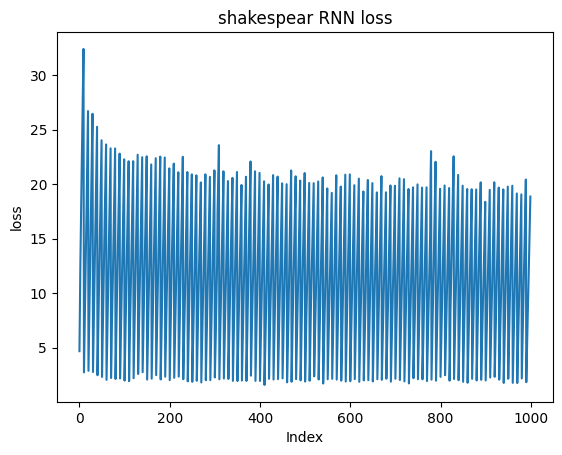

In [49]:
# Create an array for the x values which are the indices of the array
x_values = np.arange(len(shakespear_lstm_loss ))
plt.plot(x_values, shakespear_lstm_loss )
plt.xlabel('Index')
plt.ylabel('loss')
plt.title('shakespear RNN loss')
plt.show()

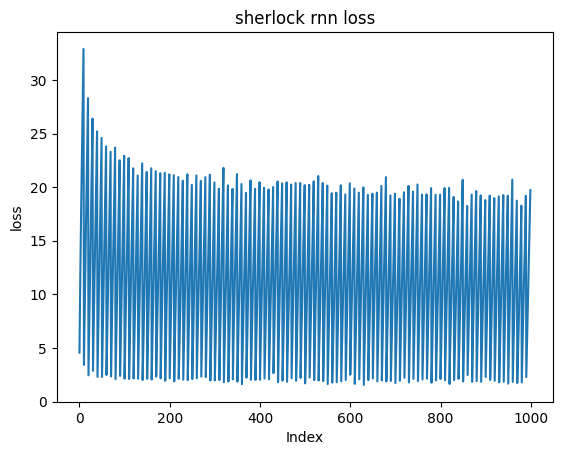

In [51]:
import matplotlib.pyplot as plt
# Create an array for the x values which are the indices of the array
x_values = np.arange(len(shelock_lstm_loss ))
plt.plot(x_values,shelock_lstm_loss )
plt.xlabel('Index')
plt.ylabel('loss')
plt.title('sherlock rnn loss')
plt.show()

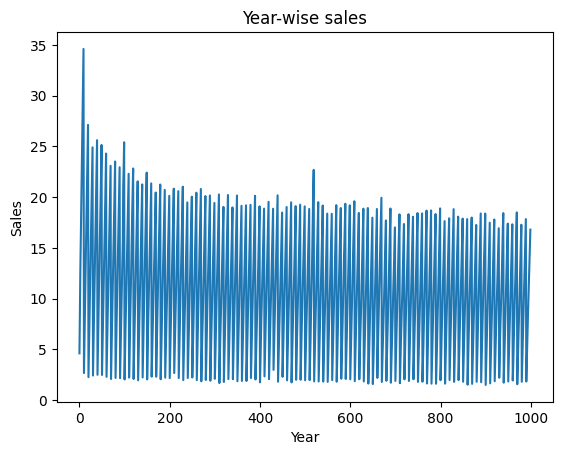

In [42]:
shelock_lstm_loss
import pandas as pd
import matplotlib.pyplot as plt
sal = {'year': range(len(shelock_lstm_loss)),
        'sales': shelock_lstm_loss}
df = pd.DataFrame(sal)
df.set_index('year', inplace=True)
plt.plot(df.index, df['sales'])
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Year-wise sales')
plt.show()

In [ ]:
for i in range(n_Q_updates):
    if len(priority_queue) == 0:
        break
    state, action = priority_queue.pop()
    r_pred, state_pred = model(state, action)
    # update Q function estimate
    Q_target = (r_pred + gamma * find_max_Q(state_pred)).detach()
    q_loss = (Q_target - Q(state, action)) ** 2
    optimizer.zero_grad()
    q_loss.backward()
    optimizer.step()
    # Loop to add states leading to state to the priority queue
    def look_n_step_back(state, n_step_back):
"""Look to find the states which lead to state in n_step_back steps
and add them to the priority queue if they would be updated by more
than the threshold"""
        for step in range(n_step_back):
            if n_step_back == 0
                return None
            else:
                for action in all_actions:
                    r_back,state_back=inverse_model(state,action)
                    priority = #fill in your answer
                    if priority > priority_treshotd:
                        priority_queue. add((state_back,action), priority=priority)
                        look_n_step_back(state_back,look_n_step_back(state_back,n_step_back-1))
look_n_step_back(state, n_step_back)

In [ ]:
def plan_ahead(gamma, past_actions, past_rewards, V, n_step, possible_actions, current_state):
"""
: param: gamma: float,the discount factor
: param: past_actions : a list of already planned past actions
: param: past_rewards : a list of already planned rewards
: param: V: a function which approximates the state value function
: param: n_steps: int,the number of steps we want to plan ahead from current_state
: param: possible_actions: a list of the possible actions which can be taken
: param: current_state: the current state
: return: list of 2-tupte [ (plan_l, return_l), (plan_2, return2),...] where plan is a
list of actions and return is the expected return for carrying out that list of action.
"""
if n_steps == 0:
    return_estimate = 0
    for t, r in enumerate (past_rewards):
        return_estimate += gamma ** t * r
    return_estimate+=V(current_state)*gamma**len(past_rewards)   
    return [ (past_actions, return_estimate)]
else:
    plans = []
    for action in possible_actions:
        next_r, next_state = model(current_state, action)
        next_r = next_r.item()
        finished_plans=plan_ahead(gamma,past_actions+[action],past_rewards+[next_r],V,n_steps-1,possible_actions,next_state)
    return plans

def find_best_action(gamma, past_actions, past_rewards, V, n_steps, possible_actions, current_state):
    plans = plan_ahead(gamma, past_actions, past_rewards, V, n_steps, possible_actions, current_state)
    sorted_plans=sorted(plans,key=lambda plan:plan[1],reverse=True)
    best_plan  = #fill in the blank
    best_action = #fill in the blank
    
    return best_action